# Twitter Image Classification, Recreation, and Editing

This notebook uses vision-language models to classify Twitter images and diffusion models to recreate and edit them.

If you are using AWS SageMaker, ensure you are using the [Conda PyTorch kernel](https://docs.aws.amazon.com/dlami/latest/devguide/tutorial-pytorch.html) that is specifically optimized for PyTorch-based deep learning tasks.

Please check [LBSocial](www.lbsocial.net)  on how to collect Twitter data. 


## Visoan-Language Model
A [Vision-Language Model (VLM)](https://huggingface.co/blog/vlms) is an AI model that integrates visual and textual information, enabling it to understand and generate insights from both images and text. It combines computer vision (to recognize objects and scenes) with natural language processing, allowing tasks like generating image captions, answering questions about images, and creating visuals from text prompts. 

## Diffusion Model
A [diffusion model](https://huggingface.co/blog/Esmail-AGumaan/diffusion-models) is a generative AI model that creates images by reversing a process of adding noise. It learns to transform random noise into detailed images by progressively removing noise over many steps. Starting with pure noise, the model gradually refines each step until it forms a complete, high-quality image. This approach is highly effective for text-to-image generation and image editing.





## Set up a Database and API Keys

Create a [MongoDB](www.mongodb.com) cluster and store the connection string in a safe place, such as AWS Secrets Manager. 
- key name: `connection_string`
- key value: <`the connection string`>, you need to type the password
- secret name: `mongodb`


You also need to purchase and your [oepnai](https://openai.com/) api key in AWS Secrets Manager:
- key name: `api_key`
- key value: <`your openai api key`>
- secret name: `openai`

## Install Python Libraries

- pymongo: manage the MongoDB database
- openai: use the VLM model and diffusion model

In [1]:
pip install pymongo openai -q

Note: you may need to restart the kernel to use updated packages.


## Secrets Manager Function

In [2]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

## Import Python Libraries and Credentials

In [3]:
import pymongo
from pymongo import MongoClient
import json
import re
import os
from openai import OpenAI
from pprint import pprint
from tqdm.auto import tqdm
import random


openai_api_key  = get_secret('openai')['api_key']
client = OpenAI(api_key=openai_api_key)


mongodb_connect = get_secret('mongodb')['connection_string']


## Connect to the MongoDB cluster

In [4]:
mongo_client = MongoClient(mongodb_connect)
db = mongo_client.demo # use or create a database named demo
tweet_collection = db.tweet_collection #use or create a collection named tweet_sample

## Extract Twitter Data
Filter the Tweets you are interested in. You can use MongoDB Compass to help you write the queries.

In [5]:
filter={
    'tweet.entities.urls.images': {
        '$exists': True
    }
}
project={
    'tweet.entities.urls.images': 1, 
    'tweet.id': 1
}
result = tweet_collection.find(
  filter=filter,
  projection=project
)

In [6]:
tweet_data = []
for tweet in result:
    for url in tweet['tweet']['entities']['urls']:
        if 'images' in url:
            tweet_data.append({'tweet_id':tweet['tweet']['id'],
                               'image_url':url['images'][1]['url'] # 150*150 image 
                             })


In [7]:
print('Number of images: ',len(tweet_data))

Number of images:  6


## Utility Functions

- `get_image_from_url`: Retrieve the image object from a URL.
- `display_image`: Display an image in Python.
- `image_to_bytes`: Convert an image to bytes.

In [8]:
from PIL import Image
from io import BytesIO
import requests

def get_image_from_url(image_url):
    response = requests.get(image_url)
    # print(response)
    if response.status_code == 200 :
        image = Image.open(BytesIO(response.content))
        return image
    else:
        print('image not accessible')
        return None

In [9]:
import matplotlib.pyplot as plt

def display_image(image):
    if image:
        plt.imshow(image)
        plt.axis('off')
        plt.show()

In [10]:
from io import BytesIO

def image_to_bytes(image_obj):
    buffered = BytesIO()
    image_obj.save(buffered, format="PNG")
    return buffered.getvalue()


## Classify Twitter Image

Many OpenAI [models](https://platform.openai.com/docs/models) can handle both images and text, allowing you to choose the most suitable model for your needs.

This function summarizes each Twitter image and extracts entities into a JSON document.

In [11]:
vison_model = 'gpt-4o-mini'
temperature=0

def describe_image(image_url):

    response = client.chat.completions.create(
      model=vison_model,
      messages=[
        {
          "role": "user",
          "content": [
            {"type": "text", "text": """Analyze the image included in the tweet.
                                        Briefly describe the content of the image and extract entities from it.
                                        Organize the response in a JSON document:
                                        Place the description in the <img_desc> key.
                                        List the entity type and entity value in the <img_entities> key.
                                        Do not wrap the JSON code in JSON markers."""},
            {
              "type": "image_url",
              "image_url": {"url": image_url,},
 
            },
          ],
        }

      ],
    temperature=temperature
     )
    return (response.choices[0].message.content)

In [12]:
for tweet in tqdm(tweet_data):
    
    try:
        image_result =json.loads(describe_image(tweet['image_url']))
        tweet['image_desc']=image_result['img_desc']
        tweet_collection.update_one(
                {'tweet.id':tweet['tweet_id']},
                {"$set":{'tweet.img_desc':image_result['img_desc'], 
                        'tweet.img_entities':image_result['img_entities']}}
        )
    except:
        pass

  0%|          | 0/6 [00:00<?, ?it/s]

### Visualize the extracted items in MongoDB:

- Apply the filter: `{'tweet.img_desc': {$ne: null}}` to ensure only tweets with image descriptions are included.


In [13]:
import pandas as pd
import seaborn as sns
from collections import Counter

tweets = list(tweet_collection.find({'tweet.img_desc': {'$ne': None}}))

# Extract entity data
entity_values = []
entity_types = []
tweet_data_with_desc=[]

for tweet in tweets:
    for url in tweet['tweet']['entities']['urls']:
        # print(url)
        if 'images' in url:
            # print(url['images'][1]['url'])
            tweet_data_with_desc.append({'tweet_id':tweet['tweet']['id'],
                               'image_url':url['images'][1]['url'] ,
                                 'image_desc':tweet['tweet']['img_desc']})
    
    entities = tweet.get('tweet', {}).get('img_entities', [])
    for entity in entities:
        entity_types.append(entity.get('entity_type'))
        entity_values.append(entity.get('entity_value'))


- Bar Chart: Use a bar chart to show the values extracted from the images.


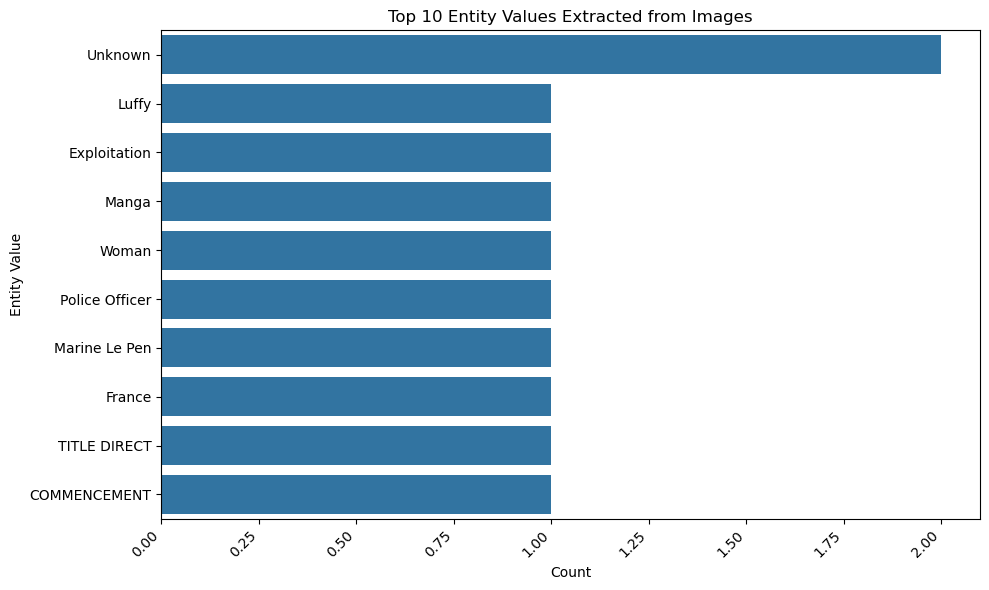

In [14]:
df_values = pd.DataFrame(Counter(entity_values).items(), columns=['Entity Value', 'Count'])

# Bar chart: Entity Values
plt.figure(figsize=(10, 6))
sns.barplot(data=df_values.sort_values(by='Count', ascending=False).head(10), y='Entity Value', x='Count')
plt.title('Top 10 Entity Values Extracted from Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- Bar Chart: Use another bar chart to display the entity types.

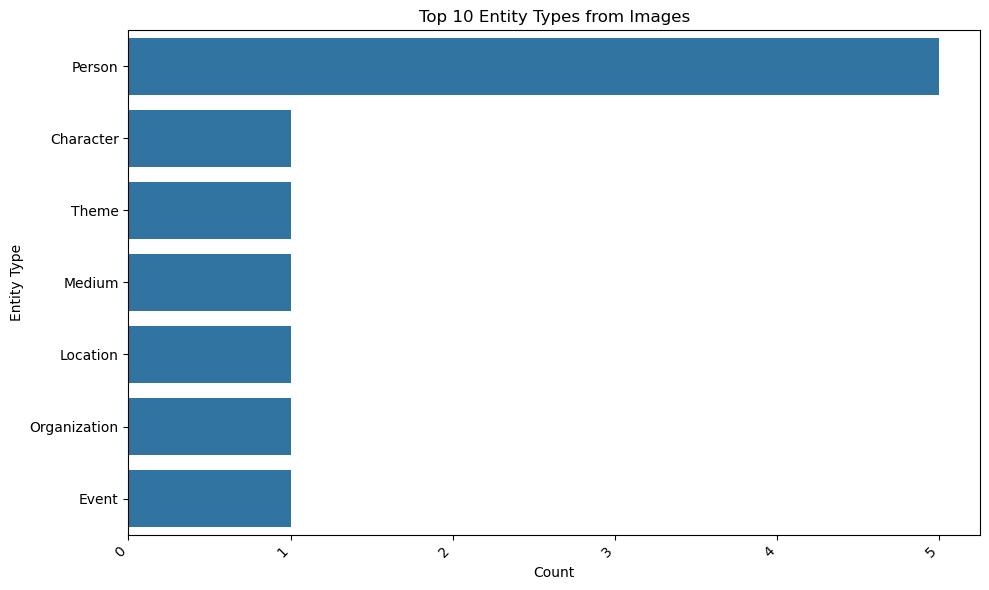

In [15]:
df_types = pd.DataFrame(Counter(entity_types).items(), columns=['Entity Type', 'Count'])

plt.figure(figsize=(10, 6))
sns.barplot(data=df_types.sort_values(by='Count', ascending=False).head(10), y='Entity Type', x='Count')
plt.title('Top 10 Entity Types from Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- Heatmap: Create a heatmap to show the relationship between the entity type and entity name.

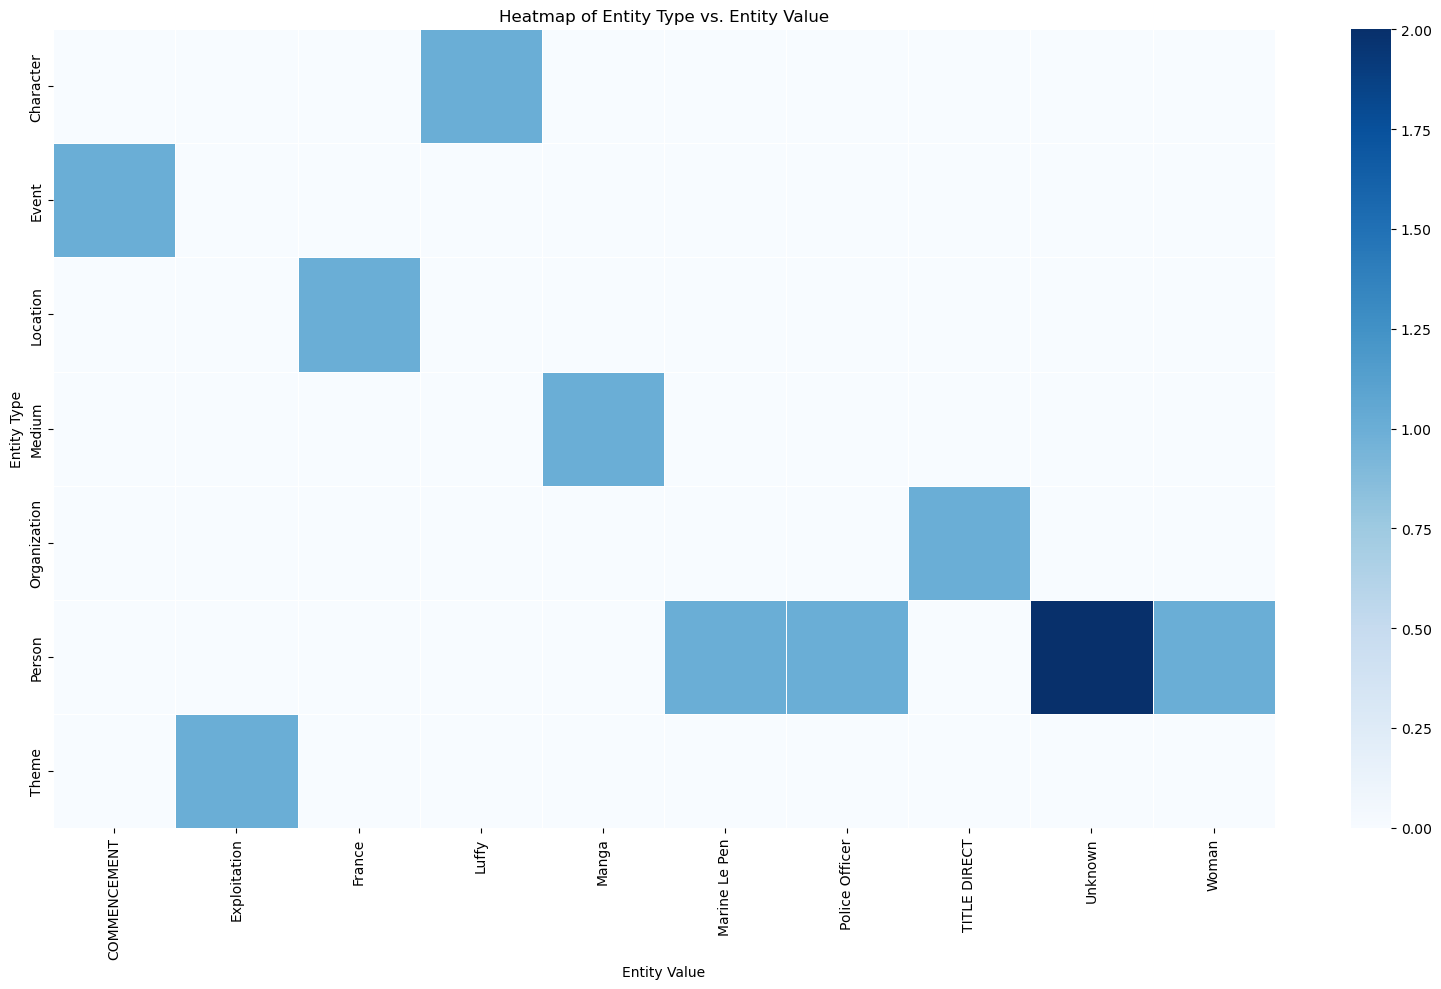

In [16]:
heatmap_data = pd.DataFrame([(e.get('entity_type'), e.get('entity_value')) 
                             for t in tweets for e in t.get('tweet', {}).get('img_entities', [])],
                            columns=['Entity Type', 'Entity Value'])
heatmap_counts = heatmap_data.groupby(['Entity Type', 'Entity Value']).size().unstack(fill_value=0)

# Heatmap: Entity Type vs Value
plt.figure(figsize=(16, 10))
sns.heatmap(heatmap_counts, cmap='Blues', linewidths=0.5)
plt.title('Heatmap of Entity Type vs. Entity Value')
plt.tight_layout()
plt.show()

### View the image and description
Randomly select an image, display it along with its description.

https://pbs.twimg.com/news_img/1906662807514324992/IiILeDDY?format=jpg&name=150x150


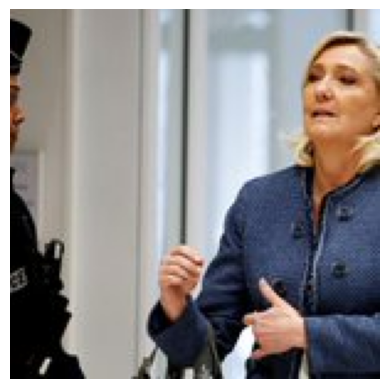

A woman in a blue jacket appears to be speaking emotionally while gesturing with her hands. A police officer in uniform stands nearby, observing the situation.


In [22]:
tweet =random.choice(tweet_data_with_desc)
print(tweet['image_url'])

display_image(get_image_from_url(tweet['image_url']))

print(tweet['image_desc'])
    

## Create Images
For image generation, you can choose between DALL·E 2 or DALL·E 3. Both models currently support different parameters. Note that only DALL·E 2 can be used to create variations or edit images. Please check the OpenAI [API documentation](https://platform.openai.com/docs/guides/images) for more details.

### Create New Image
Generate a new image based on the provided image description.

In [23]:
image_model="dall-e-2"  


def create_new_img(prompt):

    resposne = client.images.generate(
    model=image_model,
    prompt=prompt,
    n=1,
    size = "256x256"
    )
    
    
    return(resposne.data[0].url)

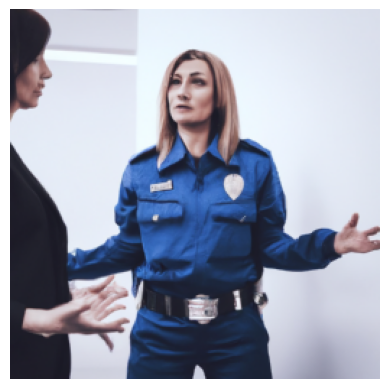

In [24]:
new_image = create_new_img(tweet['image_desc'])

display_image(get_image_from_url(new_image))

### Create Variant
Upload an existing Twitter image and create a variant.

In [25]:
def create_var_img(image_url):
    img_obj = get_image_from_url(image_url)
    img_byt = image_to_bytes(img_obj)
    response = client.images.create_variation(
        image=img_byt,
        n=1,
        size="256x256",

        )
    return (response.data[0].url)   

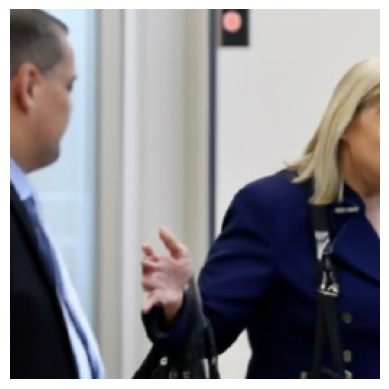

In [26]:
var_image = create_var_img(tweet['image_url'])

display_image(get_image_from_url(var_image))
                                                  

### Edit Image
Upload Twitter images, mask the desired area, and edit the masked part.

In [27]:
def create_img_edit(image, img_mask, prompt):

    response = client.images.edit(
      model="dall-e-2",
      image=image_to_bytes(image),
      mask=image_to_bytes(img_mask),
      prompt=prompt,
      n=1,
      size="256x256"
    )

    return (response.data[0].url)

### Create Mask with PyTorch
The following code is provided by ChatGPT with the prompt `"Segment image and create masks."` 

You can also use foundational models to segment images, such as Meta’s [SAM (Segment Anything Model)](https://ai.meta.com/sam2/).

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:02<00:00, 120MB/s] 


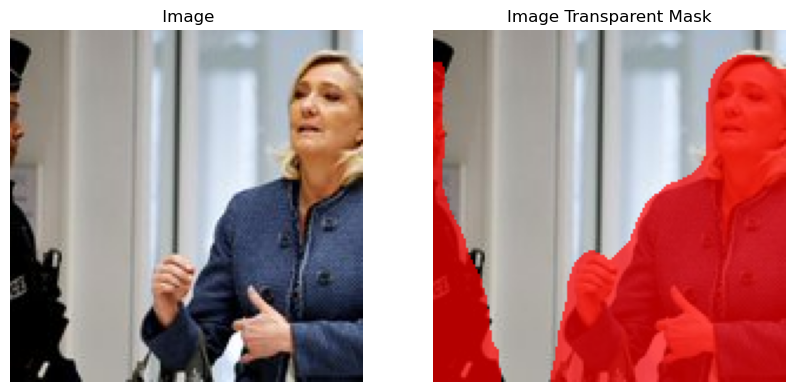

In [28]:
from torchvision import models, transforms
from PIL import Image, ImageEnhance
import torch
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO

# Load the image
image = get_image_from_url(tweet['image_url'])  # Replace with your image loading method

# Define transformations (no resizing since images are 150x150)
transform = transforms.Compose([
    transforms.ToTensor(),
])
input_image = transform(image).unsqueeze(0)  # Add batch dimension

# Load the pre-trained DeepLabV3 model
model = models.segmentation.deeplabv3_resnet101(pretrained=True)
model.eval()

# Perform segmentation
with torch.no_grad():
    output = model(input_image)['out'][0]

# Convert output to predicted classes
output_predictions = output.argmax(0).byte().numpy()


# Create a transparent RGBA mask with fully transparent non-segmented areas
height, width = output_predictions.shape
mask = np.zeros((height, width, 4), dtype=np.uint8)  # 4 channels for RGBA

# Define a color for segmented areas (e.g., semi-transparent red)
color = [255, 0, 0, 180]  # Red with 70% opacity
mask[output_predictions > 0] = color  # Apply color to segmented areas only

# Convert mask to a PIL Image
mask_image = Image.fromarray(mask, mode="RGBA")

# Overlay mask onto the contrast-enhanced original image
image_with_mask = Image.alpha_composite(image.convert("RGBA"), mask_image)

# Display the original image and transparent mask overlay
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image)
axs[0].axis('off')
axs[0].set_title(" Image")

axs[1].imshow(image_with_mask)
axs[1].axis('off')
axs[1].set_title("Image Transparent Mask")

plt.show()

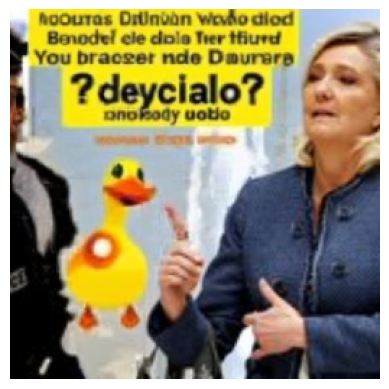

In [29]:
img_edit = create_img_edit(image,mask_image,'in the middle of a lake with yellow ducks')

display_image(
    get_image_from_url(img_edit))

## Respoisbile AI
Many image model providers update their security measures to foster responsible AI usage. For example, AWS adds watermarks to images generated by Amazon Titan. OpenAI has updated its safety features, including monitoring for abuse, access control, and the identification of images created by DALL·E 3.

## References

- Amazon Web Services, Inc. *“Watermark Detection for Amazon Titan Image Generator Now Available in Amazon Bedrock.”* Accessed November 7, 2024. [https://aws.amazon.com/about-aws/whats-new/2024/04/watermark-detection-amazon-titan-image-generator-bedrock/](https://aws.amazon.com/about-aws/whats-new/2024/04/watermark-detection-amazon-titan-image-generator-bedrock/).

- Esmail Atta Gumaan. *“Diffusion Models.”* Hugging Face (blog). Accessed November 7, 2024. https://huggingface.co/blog/Esmail-AGumaan/diffusion-models.

- Merve Noyan and Edward Beeching. *“Vision Language Models Explained.”* Hugging Face (blog). Accessed November 6, 2024. [https://huggingface.co/blog/vlms](https://huggingface.co/blog/vlms).

- *“OpenAI Safety Practices.”* Accessed November 7, 2024. [https://openai.com/index/openai-safety-update/](https://openai.com/index/openai-safety-update/).